In [2]:
import sys, os

project_root = os.path.abspath(os.path.join("..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from src.enums.PathEnums import Paths
from pathlib import Path
import pickle
import random
import shutil

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [46]:
def plot_image(image_path, label):
    
    img = Image.open(image_path)

    img_as_array = np.array(img)

    print(f"Image path: {image_path}")
    print(f"Image class: {label}")
    print(f"Image shape: {img_as_array.shape}")
    plt.imshow(img_as_array)
    plt.title(f"Random Image from '{label}' class")
    plt.axis('off')

In [47]:
def plot_images(data, labels):

    n = len(data)
    fig, axes = plt.subplots(1, n, figsize=(n * 5, 5))  

    if n == 1:
        axes = [axes]  # If only 1 image, make sure axes is iterable

    for i, image_path in enumerate(data):
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {labels[i]}")
        axes[i].axis("off")

    # plt.suptitle(f"Random Images from '{category}' class", fontsize=16)
    plt.show()

In [ ]:
class DatasetSplitter:

    def __init__(self):
        print("DatasetSplitter initialize...")

    def get_all_annotations(self):

        with open(os.path.join('../../', Paths.ANNOT_PKL.value), "rb") as f:
            videos_annot_dct = pickle.load(f)

        labels = set()
        all_annotations = []
        train_split = []
        valid_split = []
        test_split = []
        i_tr, i_v, i_ts, i_all = 0, 0, 0, 0

        train_ids = ["1", "3", "6", "7", "10", "13", "15", "16", "18", "22", "23", "31",
                    "32", "36", "38", "39", "40", "41", "42", "48", "50", "52", "53", "54"]


        val_ids = ["0", "2", "8", "12", "17", "19", "24", "26", "27", "28", "30", "33", "46", "49", "51"]

        for video_id, clips in videos_annot_dct.items(): # each video

            for clip_id, clip_data in clips.items():     # each clip

                category = clip_data['category']
                labels.add(category)

                for frame_id, boxes in clip_data["frame_boxes_dct"].items():    # Frames

                    # if str(frame_id) == str(clip_id) :
                        # print(f"===: {video_id} || {clip_id} || {frame_id}, {category}")
                    frame_path = f"{Paths.VIDEOS_ROOT.value}/{video_id}/{clip_id}/{frame_id}.jpg"
                    i_all+=1
                    all_annotations.append(
                        {
                            "path": os.path.join('../../', frame_path), 
                            "category": category
                        }
                    )
                    if str(video_id) in train_ids:
                        i_tr+=1
                        # if i_tr == 2:
                        #     print(f"{i_tr}_train: path: {frame_path}, category: {category}")
                            # plot_image(frame_path, category)
                        train_split.append({"path": os.path.join('../../', frame_path),   "category": category })
                    elif str(video_id) in val_ids:
                        i_v+=1
                        # if i_v == 3:
                        #     print(f"{i_v}_valid: path: {frame_path}, category: {category}")
                            # plot_image(frame_path, category)
                        valid_split.append({"path": os.path.join('../../', frame_path),   "category": category })
                    else:
                        i_ts+=1
                        # if i_ts == 1:
                        #     print(f"{i_ts}_test: path: {frame_path}, category: {category}")
                        #     plot_image(frame_path, category)
                        test_split.append({"path": os.path.join('../../', frame_path),   "category": category })

        print(i_tr, i_v, i_ts, i_tr+i_v+i_ts, i_all)


        random.shuffle(train_split)
        random.shuffle(valid_split)
        random.shuffle(test_split)
        random.shuffle(all_annotations)

        return all_annotations, train_split, valid_split, test_split, sorted(list(labels))
# ===================================
def split_data():
    print("Start DatasetSplitter...\n")

    splitter = DatasetSplitter()
    all_data, train_split, valid_split, test_split, labels = splitter.get_all_annotations()
    
    print("labels: ", labels, "\n")
    print(f"len data: {len(all_data)} || train: {len(train_split)} || valid: {len(valid_split)} || test: {len(test_split)}")
    print("==="*50, "\n")

    return train_split, valid_split, test_split, labels
# ==============================================
train_split, valid_split, test_split, labels = split_data()

Start DatasetSplitter...

DatasetSplitter initialize...
19368 12069 12033 43470 43470
labels:  ['l-pass', 'l-spike', 'l_set', 'l_winpoint', 'r-pass', 'r_set', 'r_spike', 'r_winpoint'] 

len data: 43470 || train: 19368 || valid: 12069 || test: 12033



In [48]:
class CustomDataset(Dataset):
    def __init__(self, data_split, labels, transform=None):
        """
        Args:
            data_split: list of dicts [{"path": ..., "category": ...}, ...]
            labels: full list of class labels
            transform: torchvision transforms
        """
        
        self.data_split = data_split
        self.labels = labels
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(labels)}
        self.transform = transform

    def __len__(self):

        return len(self.data_split)

    def __getitem__(self, idx):

        item = self.data_split[idx]
        img = Image.open(item["path"]).convert("RGB")
        label = self.class_to_idx[item["category"]]

        if self.transform:
            img = self.transform(img)

        return item["path"], img, label
# ==============================================================================

def custom_data(train_split, valid_split, test_split, labels):
    print("Start CustomDataset...\n")

   
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        ], p=0.9),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.RandomVerticalFlip(p=0.25),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])


    test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
                )
        ])

    train_dataset = CustomDataset(train_split, labels, transform=train_transforms)
    valid_dataset = CustomDataset(valid_split, labels, transform=test_transforms)
    test_dataset  = CustomDataset(test_split,  labels, transform=test_transforms)

    print(f"len train : {len(train_dataset)}")
    print(f"len valid : {len(valid_dataset)}")
    print(f"len test : {len(test_dataset)}")  

    print(valid_dataset.labels)
    print(valid_dataset.class_to_idx)
    print("="*50, "\n")
    return train_dataset, valid_dataset, test_dataset
# =======================================================================
train_split, valid_split, test_split, labels = split_data()
print("\n==================================================================================\n")
train_dataset, valid_dataset, test_dataset = custom_data(train_split, valid_split, test_split, labels)

Start DatasetSplitter...

DatasetSplitter initialize...
19368 12069 12033 43470 43470
labels:  ['l-pass', 'l-spike', 'l_set', 'l_winpoint', 'r-pass', 'r_set', 'r_spike', 'r_winpoint'] 

len data: 43470 || train: 19368 || valid: 12069 || test: 12033



Start CustomDataset...

len train : 19368
len valid : 12069
len test : 12033
['l-pass', 'l-spike', 'l_set', 'l_winpoint', 'r-pass', 'r_set', 'r_spike', 'r_winpoint']
{'l-pass': 0, 'l-spike': 1, 'l_set': 2, 'l_winpoint': 3, 'r-pass': 4, 'r_set': 5, 'r_spike': 6, 'r_winpoint': 7}



In [49]:
class_idx = train_dataset.class_to_idx
labels = train_dataset.labels
class_idx, labels

({'l-pass': 0,
  'l-spike': 1,
  'l_set': 2,
  'l_winpoint': 3,
  'r-pass': 4,
  'r_set': 5,
  'r_spike': 6,
  'r_winpoint': 7},
 ['l-pass',
  'l-spike',
  'l_set',
  'l_winpoint',
  'r-pass',
  'r_set',
  'r_spike',
  'r_winpoint'])

In [61]:
lp1, lp2 = [], []
ll1, ll2 = [], []

i=0
for d in train_split:
    lp1.append(d['path'])
    ll1.append(d['category'])
    print(d)
    i+=1
    if i==3:
        break
print("**********************================================***************************")
for i, (path, img, label) in enumerate(train_dataset):
    lp2.append(path)
    ll2.append(label)
    print(path, labels[label])
    if i ==2:
        break


{'path': '../../data/volleyball/volleyball_/videos/1/10535/10530.jpg', 'category': 'l-pass'}
{'path': '../../data/volleyball/volleyball_/videos/1/10535/10531.jpg', 'category': 'l-pass'}
{'path': '../../data/volleyball/volleyball_/videos/1/10535/10532.jpg', 'category': 'l-pass'}
**********************================================***************************
../../data/volleyball/volleyball_/videos/1/10535/10530.jpg l-pass
../../data/volleyball/volleyball_/videos/1/10535/10531.jpg l-pass
../../data/volleyball/volleyball_/videos/1/10535/10532.jpg l-pass


In [ ]:
def plot_images(data, labels):

    n = len(data)
    fig, axes = plt.subplots(1, n, figsize=(n * 5, 5))

    if n == 1:
        axes = [axes]  # If only 1 image, make sure axes is iterable

    for i, image_path in enumerate(data):
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {labels[i]}")
        axes[i].axis("off")

    # plt.suptitle(f"Random Images from '{category}' class", fontsize=16)
    plt.show()

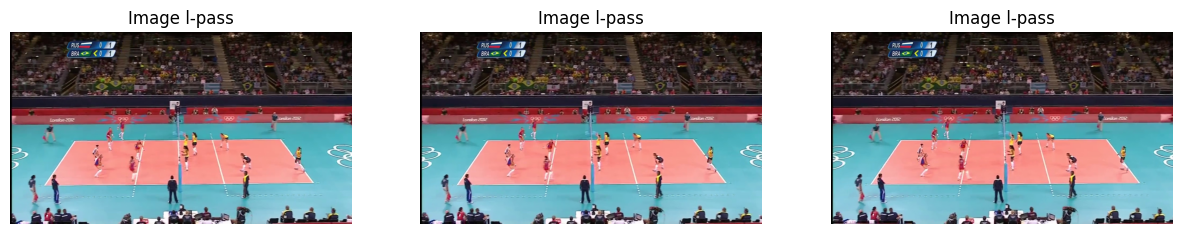

In [63]:
plot_images(lp1, ll1)

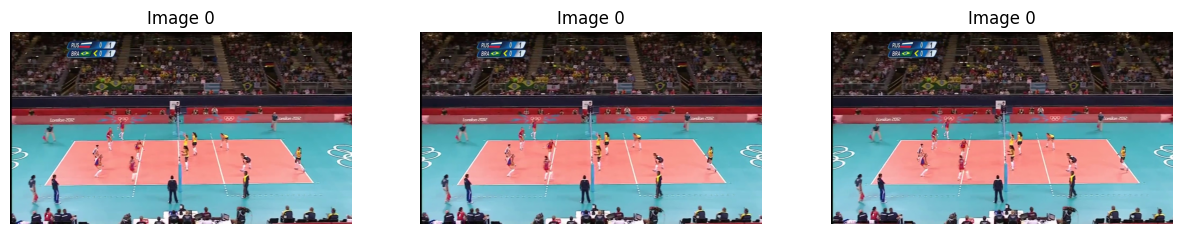

In [64]:
plot_images(lp2, ll2)

In [65]:
lp1, lp2 = [], []
ll1, ll2 = [], []

i=0
for d in test_split:
    lp1.append(d['path'])
    ll1.append(d['category'])
    print(d)
    i+=1
    if i==3:
        break
print("**********************================================***************************")
for i, (path, img, label) in enumerate(test_dataset):
    lp2.append(path)
    ll2.append(label)
    print(path, labels[label])
    if i ==2:
        break

{'path': '../../data/volleyball/volleyball_/videos/11/22120/22115.jpg', 'category': 'r-pass'}
{'path': '../../data/volleyball/volleyball_/videos/11/22120/22116.jpg', 'category': 'r-pass'}
{'path': '../../data/volleyball/volleyball_/videos/11/22120/22117.jpg', 'category': 'r-pass'}
**********************================================***************************
../../data/volleyball/volleyball_/videos/11/22120/22115.jpg r-pass
../../data/volleyball/volleyball_/videos/11/22120/22116.jpg r-pass
../../data/volleyball/volleyball_/videos/11/22120/22117.jpg r-pass


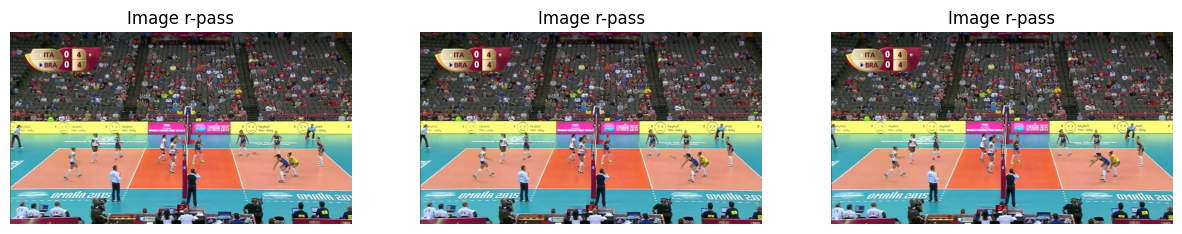

In [66]:
plot_images(lp1, ll1)

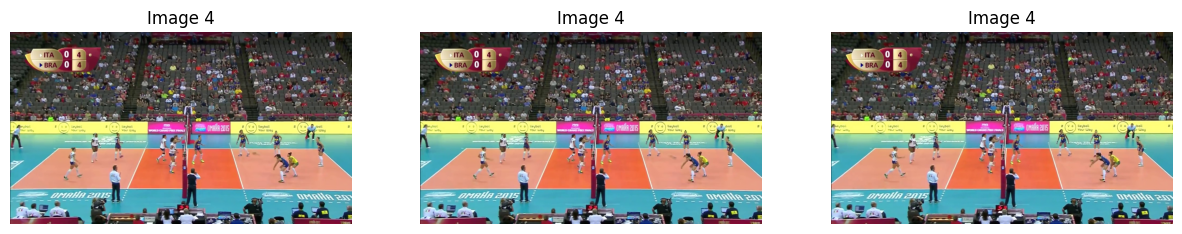

In [67]:
plot_images(lp2, ll2)

In [ ]:
lp1, lp2 = [], []
ll1, ll2 = [], []

i=0
for d in valid_split:
    lp1.append(d['path'])
    ll1.append(d['category'])
    print(d)
    i+=1
    if i==3:
        break
print("**********************================================***************************")
for i, (path, img, label) in enumerate(valid_dataset):
    lp2.append(path)
    ll2.append(label)
    print(path, labels[label])
    if i ==2:
        break

{'path': '../../data/volleyball/volleyball_/videos/0/13286/13281.jpg', 'category': 'r_set'}
{'path': '../../data/volleyball/volleyball_/videos/0/13286/13282.jpg', 'category': 'r_set'}
{'path': '../../data/volleyball/volleyball_/videos/0/13286/13283.jpg', 'category': 'r_set'}
**********************================================***************************
../../data/volleyball/volleyball_/videos/0/13286/13281.jpg r_set
../../data/volleyball/volleyball_/videos/0/13286/13282.jpg r_set
../../data/volleyball/volleyball_/videos/0/13286/13283.jpg r_set


In [ ]:
plot_images(lp1, ll1)

In [42]:
plot_images(lp2, ll2)

In [ ]:
data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

image_path_list = get_list_of_files(train_split)
random_image_path = random.choice(image_path_list)
img = Image.open(os.path.join('../..', random_image_path))
img_as_array = np.array(img)
print(f"Before Transform : {img_as_array.shape}") 
transformed_img = data_transform(img)
print(f"After Transform : {transformed_img.shape}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


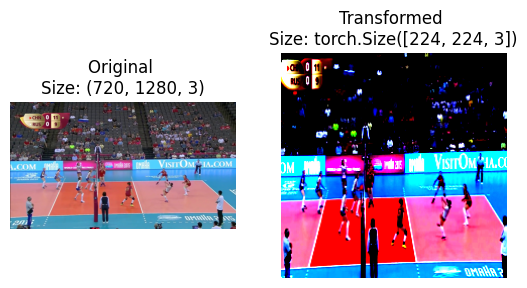

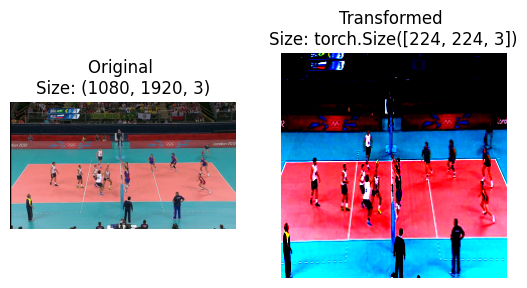

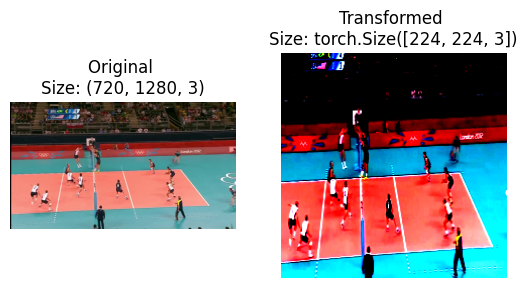

In [19]:
def plot_transformed_images(image_paths_list, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths_list, k=n)
    for image_path in random_image_paths:
        with Image.open(os.path.join('../..', image_path)) as f:
            # img_as_array = np.asarray(f)
            # print(f"Image shape: {img_as_array.shape}")
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {np.asarray(f).shape}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            
# data_transform = transforms.Compose([
#             transforms.Resize((256, 256)),
#             transforms.CenterCrop((224, 224)),
#             transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)


In [20]:
class CustomDataset(Dataset):
    def __init__(self, data_split, labels, transform=None):
        """
        Args:
            data_split: list of dicts [{"path": ..., "category": ...}, ...]
            labels: full list of class labels
            transform: torchvision transforms
        """
        self.data_split = data_split
        self.labels = labels
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(labels)}
        self.transform = transform

    def __len__(self):
        return len(self.data_split)

    def __getitem__(self, idx):
        item = self.data_split[idx]
        # img = Image.open(item["path"]).convert("RGB")
        img = Image.open(os.path.join('../..', item["path"])).convert("RGB")
        label = self.class_to_idx[item["category"]]
        if self.transform:
            img = self.transform(img)
        return img, label


In [22]:
splitter = DatasetSplitter()
train_split, valid_split, test_split, labels = splitter.split_dataset()
print(labels)
print("transform")
train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

train_dataset = CustomDataset(train_split, labels, transform=train_transforms)
valid_dataset = CustomDataset(valid_split, labels, transform=test_transforms)
test_dataset  = CustomDataset(test_split,  labels, transform=test_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


train_dataset , valid_dataset, test_dataset


['l-pass', 'l-spike', 'l_set', 'l_winpoint', 'r-pass', 'r_set', 'r_spike', 'r_winpoint']
transform


(<__main__.CustomDataset at 0x7090d6c1fc70>,
 <__main__.CustomDataset at 0x7090d6c1fc40>)

In [23]:
print(f"len train : {len(train_dataset)}")
print(f"len valid : {len(valid_dataset)}")
print(f"len test : {len(test_dataset)}")

len train : 26082
len valid : 4347
len test : 13041


In [24]:
print(valid_dataset.labels)
print(valid_dataset.class_to_idx)

['l-pass', 'l-spike', 'l_set', 'l_winpoint', 'r-pass', 'r_set', 'r_spike', 'r_winpoint']
{'l-pass': 0, 'l-spike': 1, 'l_set': 2, 'l_winpoint': 3, 'r-pass': 4, 'r_set': 5, 'r_spike': 6, 'r_winpoint': 7}


In [25]:
print(train_dataset[0])

(tensor([[[-1.0048, -0.9363, -1.2274,  ..., -1.0562, -1.3473, -1.2617],
         [-0.7479, -0.8164, -0.6794,  ..., -1.1247, -1.3302, -1.2445],
         [ 0.0227,  0.0741,  0.1254,  ..., -1.1247, -1.3130, -1.2274],
         ...,
         [ 1.0159, -0.0629,  1.1872,  ...,  1.2385, -0.0629,  0.9988],
         [ 0.2282,  0.4679,  1.4783,  ...,  1.6838,  0.1426,  0.3481],
         [-0.1143,  1.2385,  0.8447,  ...,  1.5297,  0.7248, -0.1999]],

        [[-1.0728, -0.9853, -1.2479,  ..., -0.9153, -1.2129, -1.1604],
         [-0.8102, -0.8102, -0.6176,  ..., -0.9503, -1.1954, -1.1779],
         [ 0.0126,  0.1527,  0.2227,  ..., -0.9678, -1.2129, -1.1954],
         ...,
         [ 1.8683,  0.8704,  1.9909,  ...,  1.7633,  0.6954,  1.8683],
         [ 1.1681,  1.3081,  2.2535,  ...,  2.2360,  0.9405,  1.2556],
         [ 0.8529,  1.9909,  1.8508,  ...,  2.2360,  1.6057,  0.8880]],

        [[-1.2990, -1.1073, -1.3861,  ..., -0.7064, -0.9504, -0.9678],
         [-1.4210, -1.4907, -1.3687,  ..., -

In [26]:
image, label = train_dataset[0]
class_names = train_dataset.labels
class_to_idx = train_dataset.class_to_idx

In [27]:
class_names

['l-pass',
 'l-spike',
 'l_set',
 'l_winpoint',
 'r-pass',
 'r_set',
 'r_spike',
 'r_winpoint']

In [28]:
class_to_idx

{'l-pass': 0,
 'l-spike': 1,
 'l_set': 2,
 'l_winpoint': 3,
 'r-pass': 4,
 'r_set': 5,
 'r_spike': 6,
 'r_winpoint': 7}

In [29]:
print(image.shape)
print(label)
print(class_names[label])

torch.Size([3, 224, 224])
2
l_set


In [30]:
import torch

In [31]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes,  #: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = 42):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    print(random_samples_idx)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3464, 3678, 343]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


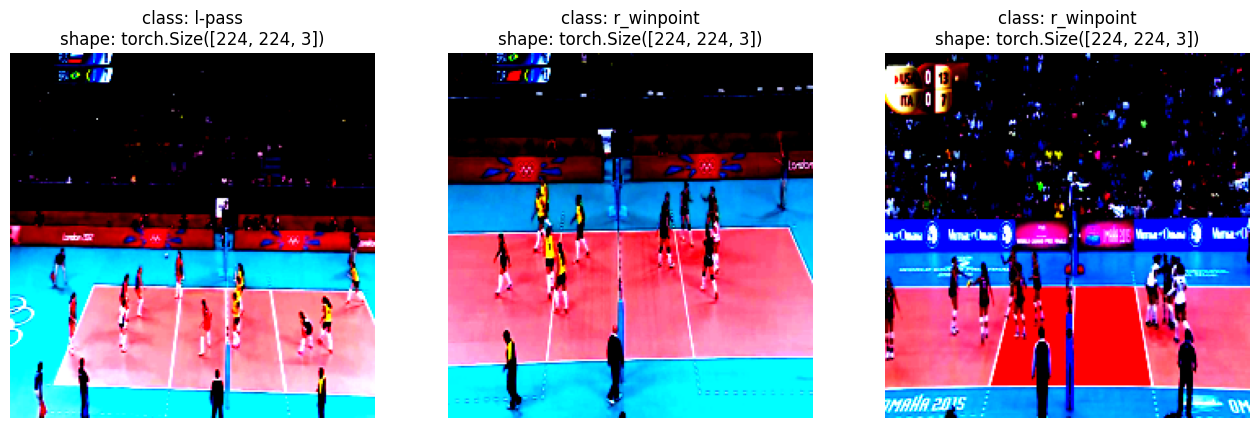

In [32]:
display_random_images(valid_dataset, 
                      n=3, 
                      classes=class_names,
                      seed=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3454, 11035, 70]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


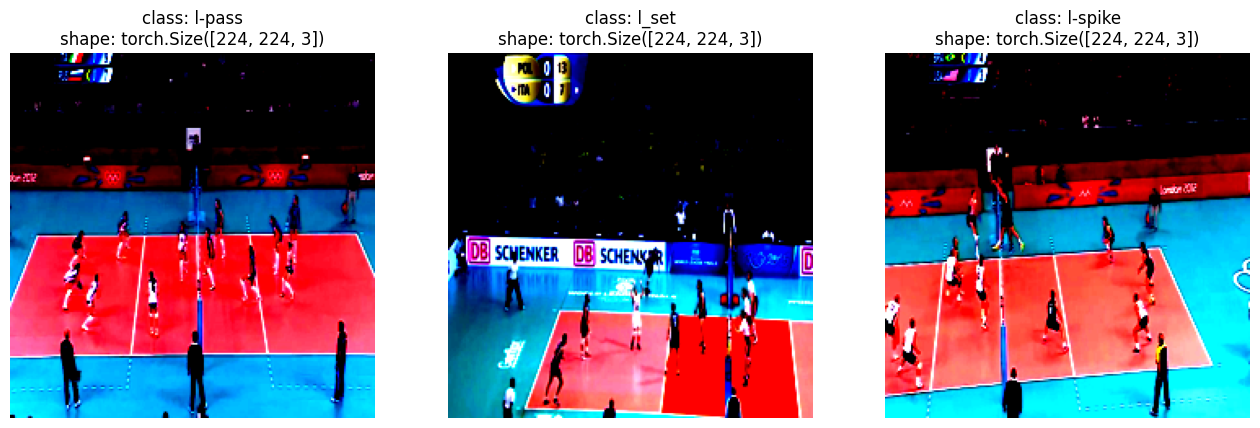

In [125]:
display_random_images(test_dataset, 
                      n=3, 
                      classes=class_names,
                      seed=None)

In [33]:
BATCH_SIZE = 32
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"Length of valid dataloader: {len(valid_dataloader)} batches of {valid_dataloader.batch_size}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7090d6c1feb0>, <torch.utils.data.dataloader.DataLoader object at 0x7090d6c1fdf0>)
Length of train dataloader: 816 batches of 32
Length of test dataloader: 408 batches of 32
Length of valid dataloader: 136 batches of 32


In [34]:
print(train_dataloader.batch_size)
print(test_dataloader.dataset)

32


In [35]:
l=0
for i in train_dataloader:  # i(list of tensors) ==> [Batch([32, 1, 28, 28]), labels([32])]
    print("Batch",l+1)
    # print(type(i)) # List
    print("size of i:", len(i))              # Size = 2 List 
    print("shape of batch data: i[0] :", i[0].shape,"labels:i[1] :", i[1].shape) # Tensor, Tensor
    print("shape of first image in batch", i[0][0].shape)
    l+=1
    if (l==2):
        break

Batch 1
size of i: 2
shape of batch data: i[0] : torch.Size([32, 3, 224, 224]) labels:i[1] : torch.Size([32])
shape of first image in batch torch.Size([3, 224, 224])
Batch 2
size of i: 2
shape of batch data: i[0] : torch.Size([32, 3, 224, 224]) labels:i[1] : torch.Size([32])
shape of first image in batch torch.Size([3, 224, 224])


In [36]:
print("=========================")
for batch, i in enumerate (train_dataloader):  # c (Counter), i ==> [Batch([32, 1, 28, 28]), labels([32])]
    print("Batch", batch, "===> ", i[0].shape, i[1].shape)
    if batch == 5:
        break

Batch 0 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 1 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 2 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 3 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 4 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 5 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])


In [37]:
for batch, (images, labels) in enumerate(train_dataloader):
    print(f"Batch {batch + 1}:")  
    print(f"  Batch Images shape: {images.shape}")   # [32, 1, 28, 28]
    print(f"  Batch Labels shape: {labels.shape}")   # [32]
    
    print(f"  Single Images: {images[0].shape}")
    print(f"  Single Label: {labels[0].item()}")
    print(f"  Label: {class_names[labels[0].item()]}")
    break 

Batch 1:
  Batch Images shape: torch.Size([32, 3, 224, 224])
  Batch Labels shape: torch.Size([32])
  Single Images: torch.Size([3, 224, 224])
  Single Label: 3
  Label: l_winpoint


In [38]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Model

In [40]:
# !pip install torchinfo

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchinfo  import summary

In [43]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/zeus/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


In [164]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
summary(resnet50, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [47]:
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [49]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_params(resnet50)
print(f"\nTotal parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")


Total parameters: 25,557,032
Trainable parameters: 25,557,032


In [50]:
resnet50_param_cpy = list(resnet50.parameters())

for param in resnet50_param_cpy:
    print(param.shape)
    print("Before:", param.requires_grad)
    param.requires_grad = False
    print("After :", param.requires_grad)
    break

torch.Size([64, 3, 7, 7])
Before: True
After : False


In [53]:
num_classes = len(class_names)
class_names, num_classes

(['l-pass',
  'l-spike',
  'l_set',
  'l_winpoint',
  'r-pass',
  'r_set',
  'r_spike',
  'r_winpoint'],
 8)

In [54]:
in_features = resnet50.fc.in_features
print("===================================")
resnet50.fc = nn.Linear(in_features, num_classes)
print(f" Final layer replaced: {in_features} → {num_classes}")
print(resnet50.fc)

 Final layer replaced: 2048 → 8
Linear(in_features=2048, out_features=8, bias=True)


In [55]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [60]:
image_tst = train_features_batch[0].unsqueeze(0)
image_tst.shape

torch.Size([1, 3, 224, 224])

In [62]:
# dummy_input = torch.randn(1, 3, 224, 224)
out = resnet50(image_tst)
print("\nForward pass output shape:", out.shape)


Forward pass output shape: torch.Size([1, 8])


In [85]:
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
print("  Loaded pretrained ResNet50 (ImageNet weights)")


for param in model.parameters():
    param.requires_grad = False
print("   Backbone frozen (only final FC will train)")

# Replace final layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
print(f"   Final layer replaced: {in_features} → {num_classes}")

# Training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.to(device)


cpu
  Loaded pretrained ResNet50 (ImageNet weights)
   Backbone frozen (only final FC will train)
   Final layer replaced: 2048 → 8


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [64]:
train_dataloader

In [86]:
from torchmetrics import Accuracy
acctorch = Accuracy(task="multiclass", num_classes=len(class_names))
from timeit import default_timer as timer
acctorch

MulticlassAccuracy()

In [92]:
model.train() # put model in train mode
train_loss, train_acc = 0.0, 0.0


for batch, (X, y) in enumerate(train_dataloader):
    # Send data to GPU
    X, y = X.to(device), y.to(device)

    print(f"X shape: {X.shape}, label shape: {y.shape}")

    # Forward
    y_pred = model(X)
    loss = criterion(y_pred, y)

        # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Metrics
    train_loss += loss.item()
    print("ACC Torch", acctorch(y_pred.argmax(dim=1), y))
    train_acc = acctorch(y_pred.argmax(dim=1), y)

    print(f"trai loss : {train_loss}")
    print(f"train acc : {train_acc}")
    print(f"Batch: =================> {batch}")
     break

# Calculate loss and accuracy per epoch and print out what's happening
avg_loss  = train_loss / len(train_dataloader)
avg_acc = acctorch.compute()
avg_acc = avg_acc.item()
print("ggg", avg_acc, avg_acc*100)
acctorch.reset()
print(f"Train loss: {avg_loss:.5f} | Train accuracy: {avg_acc:.2f}")


X shape: torch.Size([32, 3, 224, 224]), label shape: torch.Size([32])
ACC Torch tensor(0.1875)
trai loss : 2.093148708343506
train acc : 0.1875
Batch: =================> 0
ggg 0.1875 18.75
Train loss: 0.00257 | Train accuracy: 0.19


In [82]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    

    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() 
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)   
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

Batch : 0 ==============
torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 8])
tensor(0.1875)
Train loss: 0.00241 | Train accuracy: 0.19% | Train accuracy torch: 0.02%


In [ ]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [72]:
epochs_count = []
loss_values = []
test_loss_values = []
# Measure time
from timeit import default_timer as timer
torch.manual_seed(43)
train_time_start_on_gpu = timer()

epochs = 1
for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )
    train_time_end_on_gpu = timer()
    total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                                end=train_time_end_on_gpu,
                                                device=device)
  

epock => 1
inputs shape: torch.Size([32, 3, 224, 224]), labels: torch.Size([32])
out shape: torch.Size([32, 8])

Epoch 1 → Train Loss: 0.0026, Train Acc: 0.1250


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torchmetrics.classification import Accuracy
from timeit import default_timer as timer
from tqdm import tqdm

In [94]:
avg_acc, avg_acc*100

(0.1875, 18.75)

In [167]:
class ResNet50Finetuner(nn.Module):
    def __init__(self, num_classes: int, freeze_backbone: bool = True, lr: float = 1e-3):
        """
        Fine-tuned ResNet50 model.

        Args:
            num_classes (int): number of classes in your dataset.
            freeze_backbone (bool): if True, freeze feature extractor and only train FC head.
            lr (float): learning rate for optimizer.
        """
        super().__init__()

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Load pretrained ResNet50
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        print("  Loaded pretrained ResNet50 (ImageNet weights)")

        # Freeze backbone if required
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
            print("   Backbone frozen (only final FC will train)")
        else:
            print("   All layers are trainable")

        # Replace final layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        # for p in self.model.fc.parameters():
        #     p.requires_grad = True
        print(f"   Final layer replaced: {in_features} → {num_classes}")

        # Training components
        self.criterion = nn.CrossEntropyLoss()
        self.acctorch = Accuracy(task="multiclass", num_classes=num_classes).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.1)

        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def explore(self, input_size=(1, 3, 224, 224)):
        """
        Print model summary and param counts.
        """
        print("\n--- Model Summary ---\n")
        summary(self.model, input_size=input_size)

        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"\n   Total parameters: {total:,}")
        print(f"     Trainable parameters: {trainable:,}")

    def print_train_time(self, start: float, end: float):
        total_time = end - start
        print(f"Train time on {self.device}: {total_time:.3f} seconds")
        return total_time

    def train_step(self,
               data_loader: torch.utils.data.DataLoader
                ):
        
        self.model.train() # put model in train mode
        train_loss = 0.0


        for batch, (X, y) in enumerate(data_loader):
            # Send data to GPU
            X, y = X.to(self.device), y.to(self.device)

            # Forward
            y_pred = self.model(X)
            loss = self.criterion(y_pred, y)

             # Backward
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Metrics
            train_loss += loss.item()
            self.acctorch(y_pred.argmax(dim=1), y)
    
        # Calculate loss and accuracy per epoch and print out what's happening
        avg_loss  = train_loss / len(data_loader)
        avg_acc = self.acctorch.compute()
        avg_acc = avg_acc.item()
        self.acctorch.reset()
        print(f"Train loss: {avg_loss:.5f} | Train accuracy: {avg_acc*100}")

        return avg_loss, avg_acc


    def test_step(self,
                data_loader: torch.utils.data.DataLoader
                ):
        
        self.model.eval() 
        test_loss = 0
        
        with torch.inference_mode(): 
            for X, y in data_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                test_pred = self.model(X)
                loss = self.criterion(test_pred, y)


                test_loss += loss.item()
                self.acctorch(test_pred.argmax(dim=1), y)
            
            avg_loss  = test_loss / len(data_loader)
            avg_acc = self.acctorch.compute()
            avg_acc = avg_acc.item()
            self.acctorch.reset()
            print(f"Test loss: {avg_loss:.5f} | Test accuracy: {avg_acc}%\n")
            return avg_loss, avg_acc

    def train_model(self, train_dataloader, valid_dataloader, epochs=5):
        """
        Train the model with optional validation.

        Args:
            train_loader: DataLoader for training data
            valid_loader: DataLoader for validation data
            epochs (int): number of training epochs
        """
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
        
    
        start_time = timer()
        best_val_acc = 0

        for epoch in range(1, epochs+1):

            print(f"Epoch: {epoch}/{epochs}\n---------")
            train_loss, train_acc = self.train_step(train_dataloader)
            val_loss, val_acc = self.test_step(valid_dataloader)


            print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc*100:.2f}%")
            print(f"Val   loss: {val_loss:.4f} | Val   acc: {val_acc*100:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save_model("best_resnet50.pth")

            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

        end_time = timer()
        total_train_time_model_1 = self.print_train_time(start=start_time,
                                                        end=end_time
                                                        )
        return history

    def predict(self, x: torch.Tensor):
        """Predict class for a single input tensor"""
        self.model.eval()
        with torch.inference_mode():
            x = x.unsqueeze(0).to(self.device)
            y_pred = self.model(x)
            return int(y_pred.argmax(dim=1).item())

    def save_model(self, path="resnet50.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")
    def load_model(self, path="resnet50.pth"):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.to(self.device)
        print(f"Model loaded from {path}")
    def plot_history(self, history: dict):
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["val_loss"], label="Val Loss")
        plt.title("Loss")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot([x*100 for x in history["train_acc"]], label="Train Acc")
        plt.plot([x*100 for x in history["val_acc"]], label="Val Acc")
        plt.title("Accuracy")
        plt.legend()
        plt.show()

In [168]:

num_classes = 8  
model = ResNet50Finetuner(num_classes=num_classes, freeze_backbone=True)
model.explore(input_size=(1, 3, 224, 224))

# Test forward pass
dummy_input = torch.randn(1, 3, 224, 224)
out = model(dummy_input)
print("\nForward pass output shape:", out.shape)  # should be [1, num_classes]

Loaded pretrained ResNet50 (ImageNet weights)
Backbone frozen (only final FC will train)
 Final layer replaced: 2048 → 8

--- Model Summary ---


   Total parameters: 23,524,424
     Trainable parameters: 16,392

Forward pass output shape: torch.Size([1, 8])


In [ ]:


num_classes = 8
model = ResNet50Finetuner(num_classes=num_classes, freeze_backbone=True, lr=1e-3, use_scheduler=True)

model.explore(input_size=(1,3,224,224))

history = model.train_model(train_loader, val_loader, epochs=3)

model.plot_history(history)

sample_image, _ = val_dataset[0]  
pred_class = model.predict(sample_image)
print(f"Predicted class: {pred_class}")

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

num_classes = 8
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights=None)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model.load_state_dict(torch.load(r"../../bbest_resnet50.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # إضافة بعد الـ batch
    image = image.to(device)

    with torch.inference_mode():
        outputs = model(image)
        predicted_class = outputs.argmax(dim=1).item()
    return predicted_class

# {'l-pass': 0, 'l-spike': 1, 'l_set': 2, 'l_winpoint': 3, 'r-pass': 4, 'r_set': 5, 'r_spike': 6, 'r_winpoint': 7}
# data/volleyball/volleyball_/videos/0/13286/13281.jpg ==> r_set
# 'path': 'data/volleyball/volleyball_/videos/31/31295/31295.jpg', r_spike


image_path = r"../../data/volleyball/volleyball_/videos/0/13286/13273.jpg"
# image_path = r"../../data/volleyball/volleyball_/videos/31/31295/31295.jpg"

pred_class = predict_image(image_path)
print(f"Predicted class: {pred_class}")